## Study of the score calibration used by HH-Suite

The neural network calibration used by default in HHsearch/HHblits/HHalign controls how hit score value is converted to the reported $P{\text -}value, E{\text -}value$, and $Probability$ for each reported hit.<br>
In HH-Suite v.2.x there is an option, "-calm" that can switch off this mode, whereas in HH-Suite v.3.x this option was deleted.<br>
See the [User Guide](https://github.com/soedinglab/hh-suite/wiki#dont-i-need-to-calibrate-my-query-or-database-hmm) for brief description of this feature.

Note: Use **Shift+Enter** to execute the code cells below. The order of execution is important (top to bottom). When some cell is modified it should be re-executed (all the dependent cells might also need update, **Cell/Run All Below** menu command does this).<br>**Ctrl-Z** undoes cell changes.<br>
**Kernel/Restart** menu command restarts the notebook from clean state.

In [1]:
import os
import sys
import csv
import math
import copy as cp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

%pylab inline
# print(numpy.__version__)
# print(matplotlib.__version__)

Populating the interactive namespace from numpy and matplotlib


These functions are adapted from HH-Suite 2.0.16 C++ code:

In [2]:
class Hit:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
    def __repr__(self):
        return str(self.__dict__)

def CalculatePvalues(h):
    log1000 = math.log(1000.0)
    query_log_len = math.log(h.q_L)/log1000
    hit_log_len = math.log(h.t_L)/log1000
    h.lamda = lamda_NN(query_log_len, hit_log_len, h.q_Neff/10.0, h.t_Neff/10.0)
    h.mu = mu_NN(query_log_len, hit_log_len, h.q_Neff/10.0, h.t_Neff/10.0)
    h.logPval = logPvalue(h.score,h.lamda,h.mu)
    h.Pval = Pvalue(h.score,h.lamda,h.mu)
    h.Eval = math.exp(h.logPval + math.log(h.N_searched))
    h.logEval = h.logPval + math.log(h.N_searched)
    if h.logPval < -10.0:
        x = h.logPval
    else:
        x = math.log(-math.log(1-h.Pval))
    h.score_aass = x/0.45 - min(h.lamda*h.score_ss,max(0.0,0.2*(h.score-8.0)))/0.45 - 3.0
    h.Probab = Probab(-h.score_aass, h.score_ss != 0.0)

def calc_hidden_output(weights, bias, Lqnorm, Ltnorm, Nqnorm, Ntnorm):
    "Calculate output of hidden neural network units"
    # Calculate activation of hidden unit = sum of all inputs * weights + bias
    res = Lqnorm*weights[0] + Ltnorm*weights[1] + Nqnorm*weights[2] + Ntnorm*weights[3] + bias
    res = 1.0 / (1.0 + math.exp(-(res))) # logistic function
    return res

def lamda_NN(Lqnorm, Ltnorm, Nqnorm, Ntnorm):
    "Neural network regressions of lamda for EVD"
    inputs = 4
    hidden = 4
    biases = [-0.73195, -1.43792, -1.18839, -3.01141] # bias for all hidden units
    weights = [ # Weights for the neural networks (column = start unit, row = end unit)
        -0.52356, -3.37650, 1.12984, -0.46796,
        -4.71361, 0.14166, 1.66807, 0.16383,
        -0.94895, -1.24358, -1.20293, 0.95434,
        -0.00318, 0.53022, -0.04914, -0.77046,
        2.45630, 3.02905, 2.53803, 2.64379
    ]
    lamda=0.0
    for h in range(hidden):
        lamda += calc_hidden_output(weights[inputs*h:], biases[h], Lqnorm,Ltnorm,Nqnorm,Ntnorm) * weights[hidden*inputs+h]
    return lamda

def mu_NN(Lqnorm, Ltnorm, Nqnorm, Ntnorm):
    "Neural network regressions of mu for EVD"
    inputs = 4
    hidden = 6
    biases = [-4.25264, -3.63484, -5.86653, -4.78472, -2.76356, -2.21580]  # bias for all hidden units
    weights = [ # Weights for the neural networks (column = start unit, row = end unit)
        1.96172, 1.07181, -7.41256, 0.26471,
        0.84643, 1.46777, -1.04800, -0.51425,
        1.42697, 1.99927, 0.64647, 0.27834,
        1.34216, 1.64064, 0.35538, -8.08311,
        2.30046, 1.31700, -0.46435, -0.46803,
        0.90090, -3.53067, 0.59212, 1.47503,
        -1.26036, 1.52812, 1.58413, -1.90409, 0.92803, -0.66871
    ]
    mu=0.0
    for h in range(hidden):
        mu += calc_hidden_output(weights[inputs*h:], biases[h], Lqnorm,Ltnorm,Nqnorm,Ntnorm) * weights[hidden*inputs+h]
    return 20.0*mu

def Pvalue(x, lamda, mu):
    h = lamda*(x-mu)
    if h > 10:
        return math.exp(-h)
    else:
        return 1.0 - math.exp(-math.exp(-h))

def logPvalue(x, lamda, mu):
    h = lamda*(x-mu)
    if h > 10:
        return -h
    else:
        if h < -2.5:
            return -math.exp(-math.exp(-h))
        else:
            return math.log((1.0 - math.exp(-math.exp(-h))))

def Probab(s, has_ss):
    """
    Calculate probability of true positive : p_TP(score)/( p_TP(score)+p_FP(score) )
    TP: same superfamily OR MAXSUB score >=0.1
    """
    if s > 200:
        return 100.0
    if has_ss:
        # local with SS
        a=math.sqrt(6000.0)
        b=2.0*2.5
        c=math.sqrt(0.12)
        d=2.0*32.0
    else:
        # local no SS
        a=math.sqrt(4000.0)
        b=2.0*2.5
        c=math.sqrt(0.15)
        d=2.0*34.0
    t = a*math.exp(-s/b) + c*math.exp(-s/d)
    return 100.0/(1.0+t*t) # ??? JS Jul'12

Hit data from HHsearch results (profile's Neff can be found in the header of HMM file).<br>
The precise $Score$, $P{\text -}value$, and $Probability$ values are taken by modifying HHsearch source.

In [13]:
# Describe hits explicitly
hits = [
# NP_690588.1_1-2474 vs. PF01728.18 (iteration_1)
Hit(score=40.7270432, score_ss=-0.0733758, q_Neff=1.0, t_Neff=11.7, q_L=2474, t_L=183, N_searched=1,
    Probab_HH=77.7733154, Pval_HH=1.50802e-05, query='NP_690588.1', query_coords='1-2474',
    target='PF01728.18', iteration='1', comment='iteration #1'),
# NP_690588.1_1166-1348 vs. PF01728.18 (iteration_2)
Hit(score=39.3617821, score_ss=-0.0733758, q_Neff=1.0, t_Neff=11.7, q_L=(1348-1166+1), t_L=183, N_searched=1,
    Probab_HH=95.1556091, Pval_HH=1.15029e-07, query='NP_690588.1', query_coords='1166-1348',
    target='PF01728.18', iteration='2', comment='iteration #2')
]

# OR read hits from a file
# csv_file = 'YP_009126871.csv'
# csv_file = 'NP_690588.csv'
csv_file = 'YP_009052475.csv'

if csv_file != '':
    f = open(csv_file)

    hits = []
    csv_reader = csv.reader(f)
    for r in csv_reader:
        if r[0] == 'Query':
            continue
        h = Hit(
            query=r[0],
            query_coords=r[1],
            target=r[2],
            iteration=r[3],
            comment=r[4],
            Probab_HH=float(r[5]),
            Pval_HH=float(r[6]),
            score=float(r[7]),
            score_ss=float(r[8]),
            q_L=int(r[9]),
            t_L=int(r[10]),
            q_Neff=float(r[11]),
            t_Neff=float(r[12]),
            N_searched=1,
           )
        hits.append(h)

print_probab_pval = True

for h in hits:
    CalculatePvalues(h)

    if print_probab_pval:
        print('HHsearch Probability:', h.Probab_HH)
        print('HHsearch P-value:', h.Pval_HH)
        print('Calculated Probability:', h.Probab)
        print('Calculated P-value:', h.Pval)
        print('')


HHsearch Probability: 80.54
HHsearch P-value: 2.7e-05
Calculated Probability: 80.43670062940751
Calculated P-value: 2.6550852490705664e-05

HHsearch Probability: 96.23
HHsearch P-value: 8.5e-08
Calculated Probability: 96.22480021169524
Calculated P-value: 8.501483946300786e-08



The above values match (with relative error $\approx$ 1e-06) which confirms that this calculation is correct.

### Probability as a function of query / target diversities

In [14]:
X = np.logspace(1, 6, num=51, base=10)
# print(X)

h = cp.copy(hits[0])

n_len = 300
n_Neff = 1

def resetHit():
    global h
    h = cp.copy(hits[0])

def getEvalueQLen(q_len):
    h.q_L = q_len
    CalculatePvalues(h)
    return h.Pval

def getEvalueTLen(t_len):
    h.t_L = t_len
    CalculatePvalues(h)
    return h.Pval

def testLengths(Z, func):
    for i, x in enumerate(X):
        # x = math.exp(logx)
        resetHit()
        Z[i] = func(x)

def getProbabQLen(q_len):
    h.q_L = q_len
    CalculatePvalues(h)
    return h.Probab

def getProbabTLen(t_len):
    h.t_L = t_len
    CalculatePvalues(h)
    return h.Probab

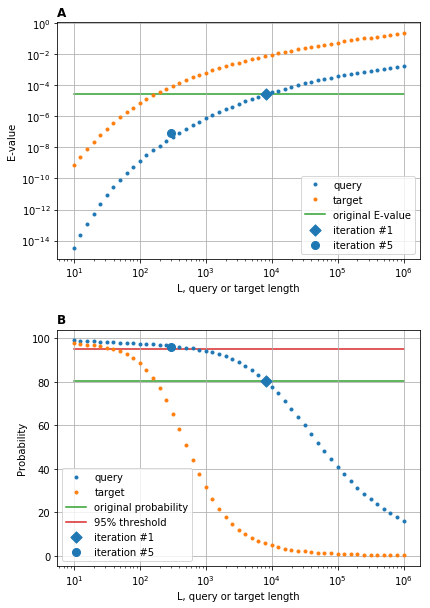

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(6.5,10)

QPval = X.copy()
testLengths(QPval, getEvalueQLen)

TPval = X.copy()
testLengths(TPval, getEvalueTLen)
# E-value = P-value (database size = 1)
color = next(ax1._get_lines.prop_cycler)['color']
markers = ['D', 'o', 'x', '+']
fix_scores = False # set to True if scores for iterations 2, 3, ... are by some reason different from iteration 1

# ax1.loglog(X, QPval, linestyle='--', label='query', c=color)
# ax1.loglog(X, TPval, linestyle='-.', label='target')
ax1.loglog(X, QPval, marker='o', markersize=3, linestyle='', label='query', c=color)
ax1.loglog(X, TPval, marker='o', markersize=3, linestyle='', label='target')
ax1.plot(X, [hits[0].Pval] * len(X), '-', zorder=0, label='original E-value')


for (i, h) in enumerate(hits):
    if i > 0 and fix_scores:
        h.score = hits[0].score
        h.score_ss = hits[0].score_ss
        CalculatePvalues(h)
    ax1.scatter([h.q_L], [h.Pval], zorder=4, label=h.comment, marker=markers[i], c=color, s=64)


ax1.set_ylabel('E-value');
ax1.legend()
ax1.grid(True)
ax1.set_title('A', weight=550, size=12, loc='left')
ax1.set_xlabel('L, query or target length')
ax1.xaxis.set_tick_params(which='both', labelbottom=True)

QPval = X.copy()
testLengths(QPval, getProbabQLen)

TPval = X.copy()
testLengths(TPval, getProbabTLen)

color = next(ax2._get_lines.prop_cycler)['color']
# ax2.semilogx(X, QPval, marker='o', markersize=1, linestyle='--', label='query', c=color)
# ax2.semilogx(X, TPval, linestyle='-.', label='target')
ax2.semilogx(X, QPval, marker='o', markersize=3, linestyle='', label='query', c=color)
ax2.semilogx(X, TPval, marker='o', markersize=3, linestyle='', label='target')
ax2.plot(X, [hits[0].Probab] * len(X), '-', zorder=0, label='original probability')
ax2.plot(X, [95] * len(X), '-', zorder=0, label='95% threshold')

for (i, h) in enumerate(hits):
    ax2.scatter([h.q_L], [h.Probab], zorder=4, label=h.comment, marker=markers[i], c=color, s=64)

ax2.set_ylabel('Probability');
ax2.legend()
ax2.grid(True)
ax2.set_title('B', weight=550, size=12, loc='left')
ax2.set_xlabel('L, query or target length')

plt.subplots_adjust(hspace=0.3)
pdffile = '{}-{}.pdf'.format(hits[0].query, hits[0].target)
plt.savefig(pdffile, format='PDF')